In [1]:
# 🧠 U-NET FOR IMAGE DENOISING
# =====================================
# Task: Remove synthetic noise from images using a simple U-Net.
# =====================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from medmnist import PathMNIST
from medmnist import INFO

# Set reproducibility
torch.manual_seed(42)

# # Prepare noisy MNIST dataset
# class NoisyMNIST(torch.utils.data.Dataset):
#     def __init__(self, train=True):
#         self.data = datasets.MNIST("data", train=train, download=True, transform=transforms.ToTensor())

#     def __getitem__(self, idx):
#         clean_img, _ = self.data[idx]
#         noise = torch.randn_like(clean_img) * 0.5
#         noisy_img = torch.clamp(clean_img + noise, 0., 1.)
#         return noisy_img, clean_img

#     def __len__(self):
#         return len(self.data)
    
# class NoisyCIFAR10(torch.utils.data.Dataset):
#     def __init__(self, train=True, noise_std=0.2):
#         self.data = datasets.CIFAR10("data", train=train, download=True,
#                                      transform=transforms.ToTensor())
#         self.noise_std = noise_std

#     def __getitem__(self, idx):
#         clean_img, _ = self.data[idx]
#         noise = torch.randn_like(clean_img) * self.noise_std
#         noisy_img = torch.clamp(clean_img + noise, 0., 1.)
#         return noisy_img, clean_img

#     def __len__(self):
#         return len(self.data)
    
# class NoisyPathMNIST(torch.utils.data.Dataset):
#     def __init__(self, split='train', noise_std=0.2):
#         info = INFO['pathmnist']
#         self.data = PathMNIST(root='data', split=split, download=True, transform=transforms.ToTensor())
#         self.noise_std = noise_std

#     def __getitem__(self, idx):
#         clean_img, _ = self.data[idx]  # shape [3, 28, 28]
#         noise = torch.randn_like(clean_img) * self.noise_std
#         noisy_img = torch.clamp(clean_img + noise, 0., 1.)
#         return noisy_img, clean_img

#     def __len__(self):
#         return len(self.data)

class UndersampledPathMNIST(torch.utils.data.Dataset):
    def __init__(self, split='train', mask_ratio=0.5):
        info = INFO['pathmnist']
        self.data = PathMNIST(root='data', split=split, download=True, transform=transforms.ToTensor())
        self.mask_ratio = mask_ratio  # percent of pixels to zero out

    def __getitem__(self, idx):
        clean_img, _ = self.data[idx]  # shape [3, 28, 28]

        # Generate binary mask with 1s for pixels to keep
        mask = (torch.rand(1, *clean_img.shape[1:]) > self.mask_ratio)
        undersampled_img = clean_img * mask  # zero out random pixels

        return undersampled_img, clean_img  # (input, target)
    
    def __len__(self):
        return len(self.data)

train_data = UndersampledPathMNIST(split='train', mask_ratio=0.5)
subset_indices = torch.randperm(len(train_data))[:50000]
train_loader = DataLoader(
    Subset(train_data, subset_indices),
    batch_size=64,
    shuffle=True,
)
test_loader = DataLoader(
    UndersampledPathMNIST(split='test', mask_ratio=0.5),
    batch_size=64,
)

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):  # Conv → BatchNorm → ReLU
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 32), CBR(32, 32))
        self.enc2 = nn.Sequential(CBR(32, 64), CBR(64, 64))
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(64, 128), CBR(128, 128))

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(64, 32), CBR(32, 32))

        self.final = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)  # [B, 32, 28, 28]
        e2 = self.enc2(self.pool(e1))  # [B, 64, 14, 14]

        b = self.bottleneck(self.pool(e2))  # [B, 128, 7, 7]

        d1 = self.up1(b)  # [B, 64, 14, 14]
        d1 = self.dec1(torch.cat([d1, e2], dim=1))  # skip connection

        d2 = self.up2(d1)  # [B, 32, 28, 28]
        d2 = self.dec2(torch.cat([d2, e1], dim=1))

        return torch.sigmoid(self.final(d2))  # Keep in [0, 1]

100%|██████████| 782/782 [04:12<00:00,  3.10it/s]


Epoch 1, Loss: 0.0036


100%|██████████| 782/782 [04:13<00:00,  3.09it/s]


Epoch 2, Loss: 0.0019


100%|██████████| 782/782 [04:15<00:00,  3.06it/s]


Epoch 3, Loss: 0.0017


100%|██████████| 782/782 [04:18<00:00,  3.03it/s]


Epoch 4, Loss: 0.0017


100%|██████████| 782/782 [04:19<00:00,  3.02it/s]


Epoch 5, Loss: 0.0016


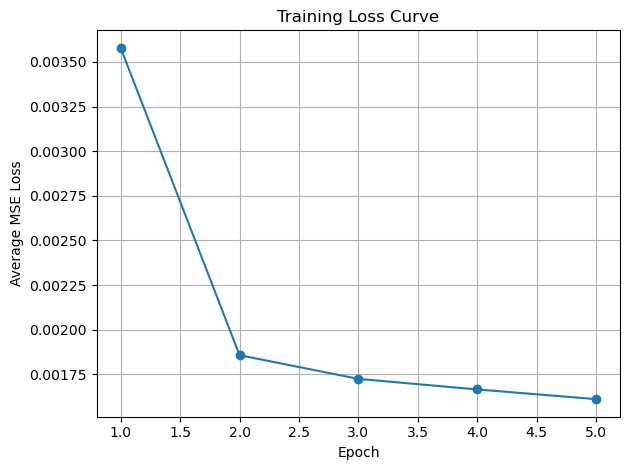

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

loss_history = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        loss = loss_fn(pred, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# 📉 Plot the loss curve
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# # Save entire model + optimizer state (for resuming training or inference)
# checkpoint = {
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()
# }
# if not os.path.exists("unet_checkpoints"):
#     os.makedirs("unet_checkpoints")
# path = "unet_checkpoints/unet_cifar10.pth"
# torch.save(checkpoint, path)
# print("Model saved to ", path)

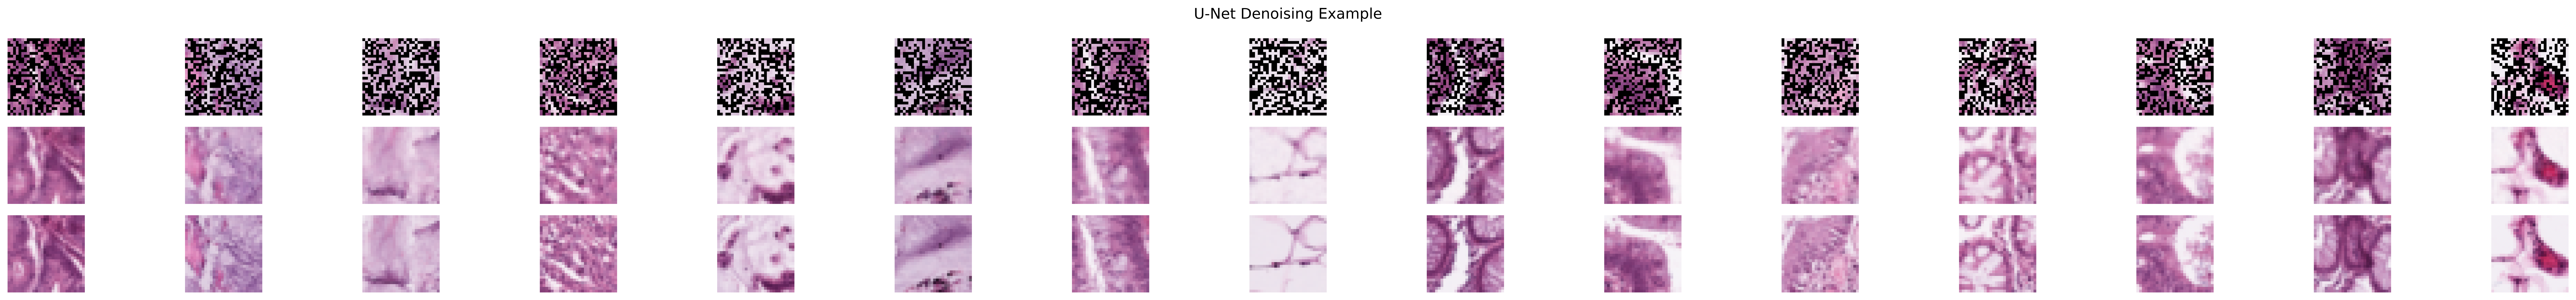

In [11]:
model.eval()
noisy_batch, clean_batch = next(iter(test_loader))
noisy_batch = noisy_batch.to(device)
with torch.no_grad():
    denoised = model(noisy_batch).cpu()

plt.figure(figsize=(36, 4), dpi=600)
for i in range(15):
    for j, img in enumerate([noisy_batch.cpu(), denoised, clean_batch]):
        plt.subplot(3, 15, i + 1 + j * 15)
        plt.imshow(img[i].permute(1, 2, 0))  # show full RGB
        plt.axis("off")
        if i == 0:
            plt.ylabel(["Noisy", "Denoised", "Clean"][j])

plt.suptitle("U-Net Denoising Example", fontsize=14)
plt.tight_layout()
plt.show()
